In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import datetime
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('final_data.csv')
df.set_index('time', inplace=True)
df_=df

In [3]:
df.head()

grid_square  internet_cdr
time                                    
01-11-13 0:00         5056    517.607260
01-11-13 0:10         5056    314.551305
01-11-13 0:20         5056    341.527327
01-11-13 0:30         5056    450.012415
01-11-13 0:40         5056    312.166782

In [4]:
df.shape

(80352, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80352 entries, 01-11-13 0:00 to 01-01-14 23:50
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   grid_square   80352 non-null  int64  
 1   internet_cdr  80352 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.8+ MB


<AxesSubplot:xlabel='internet_cdr'>

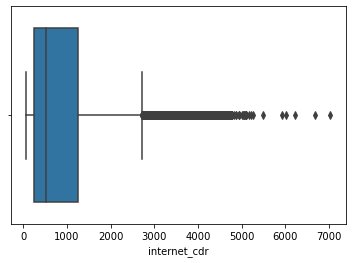

In [6]:
sns.boxplot(x=df['internet_cdr'])

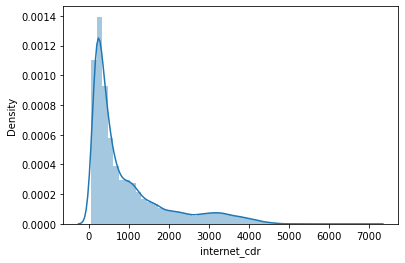

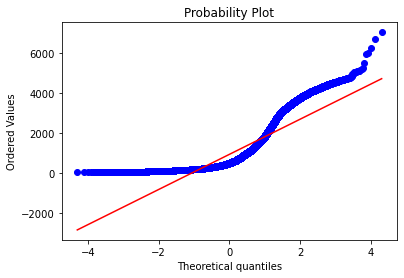

In [7]:
fig = plt.figure()
ax = fig.gca()
sns.distplot(df['internet_cdr'])
plt.show()

#Probability plot
fig = plt.figure()
res = stats.probplot(df['internet_cdr'], plot=plt)

In [8]:
df["internet_cdr"].describe()

count    80352.000000
mean       946.860543
std        997.389860
min         57.823422
25%        253.398926
50%        508.896077
75%       1243.336593
max       7033.454732
Name: internet_cdr, dtype: float64

# Seasonal-Trend Decomposition

In [9]:
from statsmodels.tsa.seasonal import STL

#### First apply on a random grid

In [10]:
random_grid=df.groupby("grid_square").get_group(5056)
random_grid.drop('grid_square', axis=1, inplace=True)
random_grid.head()

internet_cdr
time                       
01-11-13 0:00    517.607260
01-11-13 0:10    314.551305
01-11-13 0:20    341.527327
01-11-13 0:30    450.012415
01-11-13 0:40    312.166782

In [11]:
fig = px.line(random_grid.reset_index(), y='internet_cdr')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title="Random grid(5056)")
fig.show()

In [12]:
stl = STL(random_grid,period=12)
result = stl.fit()

In [13]:
seasonal = result.seasonal
trend = result.trend
resid = result.resid

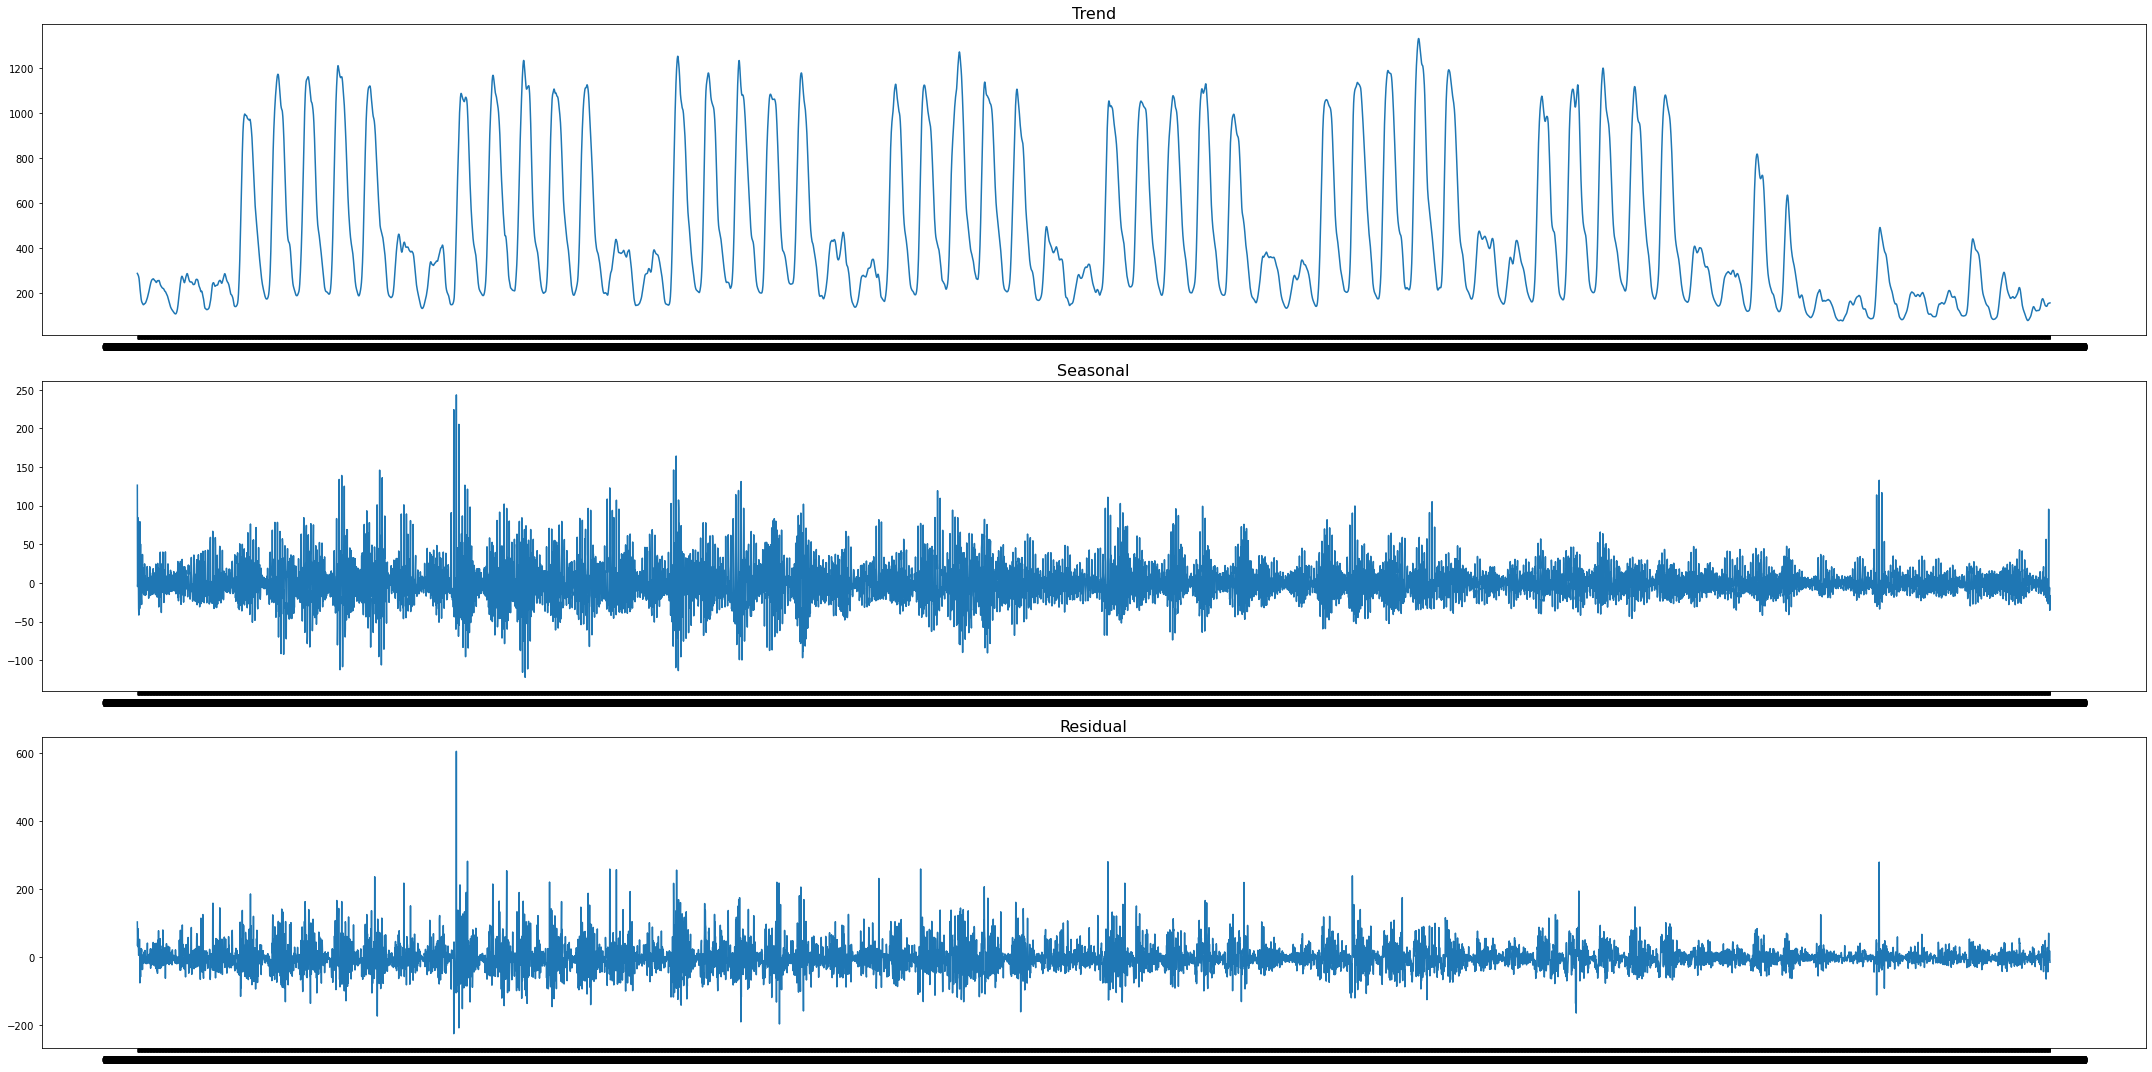

In [14]:
plt.figure(figsize=(30,15))



plt.subplot(3,1,1)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(3,1,2)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(3,1,3)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

Text(0.5, 1.0, 'Random grid(5056) plot over (trend + seasonal) plot ')

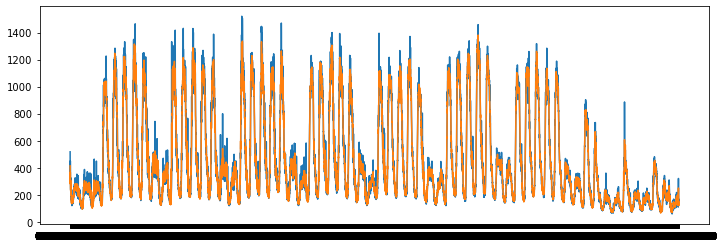

In [16]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(random_grid)
plt.plot(estimated)
ax.set_title('Random grid(5056) plot over (trend + seasonal) plot ', fontsize=20)

#### Anomaly Detection

In [17]:
random_grid = pd.concat([random_grid, resid.to_frame()], axis=1)
random_grid

internet_cdr       resid
time                                    
01-11-13 0:00     517.607260  104.021664
01-11-13 0:10     314.551305   33.870433
01-11-13 0:20     341.527327   59.077406
01-11-13 0:30     450.012415   84.207225
01-11-13 0:40     312.166782   30.642050
...                      ...         ...
01-01-14 23:10    135.564582   -3.217560
01-01-14 23:20    143.685136    0.013347
01-01-14 23:30    168.564783   19.156510
01-01-14 23:40    123.497984    3.291194
01-01-14 23:50    124.569821  -14.623582

[8928 rows x 2 columns]

In [18]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev
    
random_grid['anomaly'] = (random_grid['resid'] < lower) | (random_grid['resid'] > upper)
random_grid

internet_cdr       resid  anomaly
time                                             
01-11-13 0:00     517.607260  104.021664    False
01-11-13 0:10     314.551305   33.870433    False
01-11-13 0:20     341.527327   59.077406    False
01-11-13 0:30     450.012415   84.207225    False
01-11-13 0:40     312.166782   30.642050    False
...                      ...         ...      ...
01-01-14 23:10    135.564582   -3.217560    False
01-01-14 23:20    143.685136    0.013347    False
01-01-14 23:30    168.564783   19.156510    False
01-01-14 23:40    123.497984    3.291194    False
01-01-14 23:50    124.569821  -14.623582    False

[8928 rows x 3 columns]

In [19]:
random_grid['anomaly'].value_counts()

False    8774
True      154
Name: anomaly, dtype: int64

In [20]:
random_grid=random_grid.reset_index()
random_grid["time"] = pd.to_datetime(random_grid["time"])

In [21]:
# anomaly = full_grid.loc[full_grid['anomaly'] == True, ['internet_cdr']]
# anomaly.reset_index()

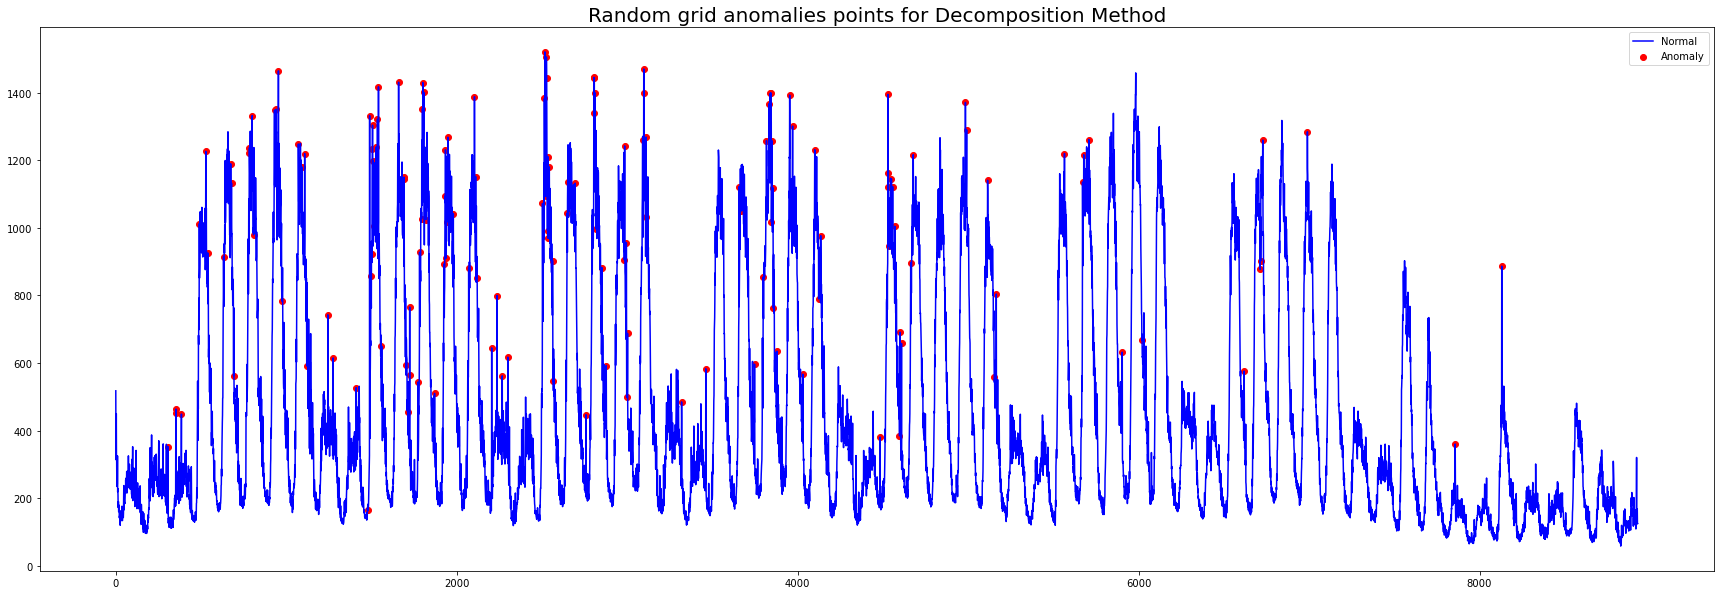

In [22]:
fig, ax = plt.subplots(figsize=(30,10))

anomaly = random_grid.loc[random_grid['anomaly'] == True, ['internet_cdr']] 

ax.plot(random_grid.index, random_grid['internet_cdr'], color='blue', label = 'Normal')
ax.scatter(anomaly.index,anomaly['internet_cdr'], color='red', label = 'Anomaly')
ax.set_title('Random grid anomalies points for Decomposition Method', fontsize=20)
plt.legend()
plt.show();

In [23]:
# fig1 = px.line(random_grid.reset_index(),  y="internet_cdr")
# fig1.update_traces(line=dict(color = 'magenta'))

# anomaly = random_grid.loc[random_grid['anomaly'] == True, ['internet_cdr']] 
# fig2 = px.scatter(anomaly,y="internet_cdr")

# fig3 = go.Figure(data=fig1.data + fig2.data)

# fig3.show()

#### Second apply on all grids

In [24]:
full_grid = df.groupby("grid_square")
grids = list(full_grid.groups.keys())

In [25]:
grids

[5056, 5057, 5058, 5156, 5157, 5158, 5256, 5257, 5258]

In [26]:
x= len(grids)

In [27]:
data=[]
for grid in grids:
    full_grid = df.groupby("grid_square").get_group(grid)
    full_grid.drop('grid_square', axis=1, inplace=True)
    data.append(full_grid)
data

[                internet_cdr
 time                        
 01-11-13 0:00     517.607260
 01-11-13 0:10     314.551305
 01-11-13 0:20     341.527327
 01-11-13 0:30     450.012415
 01-11-13 0:40     312.166782
 ...                      ...
 01-01-14 23:10    135.564582
 01-01-14 23:20    143.685136
 01-01-14 23:30    168.564783
 01-01-14 23:40    123.497984
 01-01-14 23:50    124.569821
 
 [8928 rows x 1 columns],
                 internet_cdr
 time                        
 01-11-13 0:00     403.180777
 01-11-13 0:10     310.131943
 01-11-13 0:20     308.682959
 01-11-13 0:30     357.021359
 01-11-13 0:40     303.474336
 ...                      ...
 01-01-14 23:10    161.004840
 01-01-14 23:20    135.048644
 01-01-14 23:30    157.011902
 01-01-14 23:40    164.511201
 01-01-14 23:50    146.336681
 
 [8928 rows x 1 columns],
                 internet_cdr
 time                        
 01-11-13 0:00     668.180795
 01-11-13 0:10     749.816592
 01-11-13 0:20     671.254568
 01-11-13 0:30

In [28]:
# full_decom1 = pd.DataFrame()
# full_decom2 = pd.DataFrame()
# full_decom3 = pd.DataFrame()

# stl = STL(data[1],period=12)
# result = stl.fit()
# seasonal, trend, resid = result.seasonal, result.trend, result.resid
# seasonal=   seasonal.to_frame()
# trend   =   trend.to_frame()
# resid   =   resid.to_frame()
# print("========== grid number {} done ==========".format(i+1))
# full_decom1 = full_decom1.append(seasonal)
# full_decom2 = full_decom2.append(trend)
# full_decom3 = full_decom3.append(resid)

In [29]:
seasonal_decom = pd.DataFrame()
trend_decom = pd.DataFrame()
resid_decom = pd.DataFrame()
for i in range (x):
    stl = STL(data[i],period=12)
    result = stl.fit()
    seasonal, trend, resid = result.seasonal, result.trend, result.resid
    seasonal=   seasonal.to_frame()
    trend   =   trend.to_frame()
    resid   =   resid.to_frame()
    print("========== grid number {} done ==========".format(i+1))
    seasonal_decom = seasonal_decom.append(seasonal)
    trend_decom    = trend_decom.append(trend)
    resid_decom    = resid_decom.append(resid)

========== grid number 1 done ==========
========== grid number 2 done ==========
========== grid number 3 done ==========
========== grid number 4 done ==========
========== grid number 5 done ==========
========== grid number 6 done ==========
========== grid number 7 done ==========
========== grid number 8 done ==========
========== grid number 9 done ==========


In [30]:
df = pd.concat([df, seasonal_decom,trend_decom,resid_decom], axis=1)
df

grid_square  internet_cdr      season       trend       resid
time                                                                         
01-11-13 0:00          5056    517.607260  126.434538  287.151058  104.021664
01-11-13 0:10          5056    314.551305   -4.707680  285.388552   33.870433
01-11-13 0:20          5056    341.527327   -1.066288  283.516208   59.077406
01-11-13 0:30          5056    450.012415   84.298944  281.506246   84.207225
01-11-13 0:40          5056    312.166782    2.227927  279.296805   30.642050
...                     ...           ...         ...         ...         ...
01-01-14 23:10         5258    153.632216   12.787457  137.535527    3.309232
01-01-14 23:20         5258    125.178334   -2.998953  137.458173   -9.280886
01-01-14 23:30         5258    104.560788  -23.821882  137.381282   -8.998613
01-01-14 23:40         5258    132.476372   -0.011810  137.299410   -4.811228
01-01-14 23:50         5258    123.704528   -0.847288  137.211583  -12.659766

[80352 rows x 5 columns]

####  Anomaly Detection

In [31]:
df1=df

In [32]:
data=[]
for grid in grids:
    full_grid = df.groupby("grid_square").get_group(grid)
    data.append(full_grid)
data

[                grid_square  internet_cdr      season       trend       resid
 time                                                                         
 01-11-13 0:00          5056    517.607260  126.434538  287.151058  104.021664
 01-11-13 0:10          5056    314.551305   -4.707680  285.388552   33.870433
 01-11-13 0:20          5056    341.527327   -1.066288  283.516208   59.077406
 01-11-13 0:30          5056    450.012415   84.298944  281.506246   84.207225
 01-11-13 0:40          5056    312.166782    2.227927  279.296805   30.642050
 ...                     ...           ...         ...         ...         ...
 01-01-14 23:10         5056    135.564582  -16.027409  154.809551   -3.217560
 01-01-14 23:20         5056    143.685136  -11.464713  155.136502    0.013347
 01-01-14 23:30         5056    168.564783   -6.030358  155.438631   19.156510
 01-01-14 23:40         5056    123.497984  -35.509481  155.716271    3.291194
 01-01-14 23:50         5056    124.569821  -16.7736

In [33]:
anomalies= pd.DataFrame()
for i in range (x):
    
    resid_mu = data[i]['resid'].mean()
    resid_dev = data[i]['resid'].std()

    lower = resid_mu - 3*resid_dev
    upper = resid_mu + 3*resid_dev
    

    anomaly = (data[i]['resid'] < lower) | (data[i]['resid'] > upper)
    print("========== grid number {} checked ==========".format(i+1))
    anomalies=anomalies.append(anomaly.to_frame())
    print(anomalies)


========== grid number 1 checked ==========
                resid
time                 
01-11-13 0:00   False
01-11-13 0:10   False
01-11-13 0:20   False
01-11-13 0:30   False
01-11-13 0:40   False
...               ...
01-01-14 23:10  False
01-01-14 23:20  False
01-01-14 23:30  False
01-01-14 23:40  False
01-01-14 23:50  False

[8928 rows x 1 columns]
========== grid number 2 checked ==========
                resid
time                 
01-11-13 0:00   False
01-11-13 0:10   False
01-11-13 0:20   False
01-11-13 0:30   False
01-11-13 0:40   False
...               ...
01-01-14 23:10  False
01-01-14 23:20  False
01-01-14 23:30  False
01-01-14 23:40  False
01-01-14 23:50  False

[17856 rows x 1 columns]
========== grid number 3 checked ==========
                resid
time                 
01-11-13 0:00   False
01-11-13 0:10   False
01-11-13 0:20   False
01-11-13 0:30   False
01-11-13 0:40   False
...               ...
01-01-14 23:10  False
01-01-14 23:20  False
01-01-14 23:30  False
01-

In [34]:
anomalies

resid
time                 
01-11-13 0:00   False
01-11-13 0:10   False
01-11-13 0:20   False
01-11-13 0:30   False
01-11-13 0:40   False
...               ...
01-01-14 23:10  False
01-01-14 23:20  False
01-01-14 23:30  False
01-01-14 23:40  False
01-01-14 23:50  False

[80352 rows x 1 columns]

In [35]:
df = pd.concat([df_, anomalies], axis=1).reset_index()
df["time"] = pd.to_datetime(df["time"])
df

time  grid_square  internet_cdr  resid
0     2013-01-11 00:00:00         5056    517.607260  False
1     2013-01-11 00:10:00         5056    314.551305  False
2     2013-01-11 00:20:00         5056    341.527327  False
3     2013-01-11 00:30:00         5056    450.012415  False
4     2013-01-11 00:40:00         5056    312.166782  False
...                   ...          ...           ...    ...
80347 2014-01-01 23:10:00         5258    153.632216  False
80348 2014-01-01 23:20:00         5258    125.178334  False
80349 2014-01-01 23:30:00         5258    104.560788  False
80350 2014-01-01 23:40:00         5258    132.476372  False
80351 2014-01-01 23:50:00         5258    123.704528  False

[80352 rows x 4 columns]

In [36]:
df['resid'].value_counts()

False    79094
True      1258
Name: resid, dtype: int64

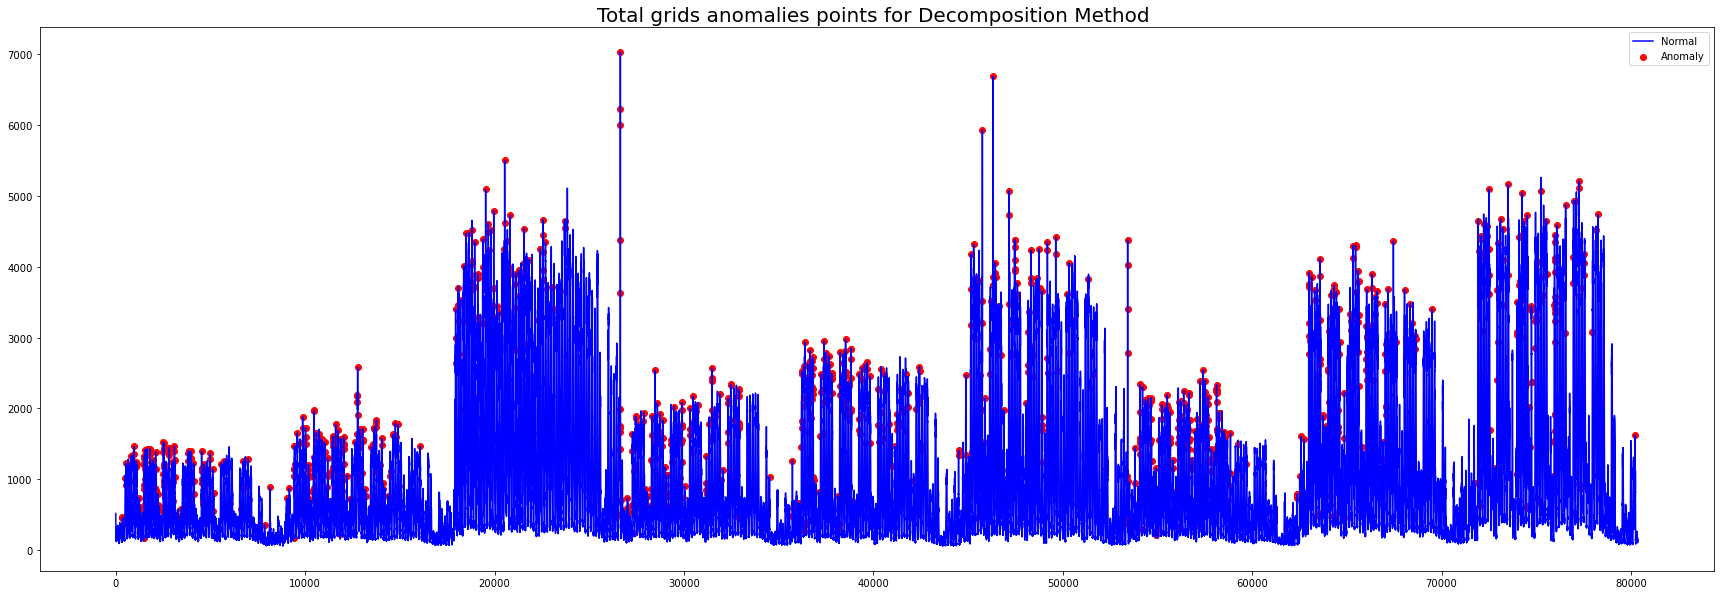

In [37]:
fig, ax = plt.subplots(figsize=(30,10))

anomaly = df.loc[df['resid'] == True, ['internet_cdr']] 

ax.plot(df.index, df['internet_cdr'], color='blue', label = 'Normal')
ax.scatter(anomaly.index,anomaly['internet_cdr'], color='red', label = 'Anomaly')
ax.set_title('Total grids anomalies points for Decomposition Method ', fontsize=20)
plt.legend()
plt.show();

In [38]:
# fig1 = px.line(df,  y="internet_cdr")
# fig1.update_traces(line=dict(color = 'turquoise'))

# anomaly = df.loc[df['resid'] == True, ['internet_cdr']] 

# fig2 = px.scatter(anomaly,y='internet_cdr')

# fig3 = go.Figure(data=fig1.data + fig2.data)

# fig3.show()

In [39]:
anomaly

internet_cdr
306      352.377304
352      451.709775
353      463.456650
385      448.798618
490     1012.517812
...             ...
77532   4187.446381
77959   3078.649034
78146   4517.146627
78269   4742.046834
80209   1619.034160

[1258 rows x 1 columns]

In [40]:
df.rename(columns = {"resid": "anomaly"}, inplace = True)

In [41]:
df

time  grid_square  internet_cdr  anomaly
0     2013-01-11 00:00:00         5056    517.607260    False
1     2013-01-11 00:10:00         5056    314.551305    False
2     2013-01-11 00:20:00         5056    341.527327    False
3     2013-01-11 00:30:00         5056    450.012415    False
4     2013-01-11 00:40:00         5056    312.166782    False
...                   ...          ...           ...      ...
80347 2014-01-01 23:10:00         5258    153.632216    False
80348 2014-01-01 23:20:00         5258    125.178334    False
80349 2014-01-01 23:30:00         5258    104.560788    False
80350 2014-01-01 23:40:00         5258    132.476372    False
80351 2014-01-01 23:50:00         5258    123.704528    False

[80352 rows x 4 columns]

In [42]:
#df.to_csv("anomaly.csv")